# __Pytorch__

I recommend to run this Jupyter notebook in Collab, using GPUs.

In [53]:
from __future__ import print_function
from __future__ import division

import os
import time

import numpy as np
import pandas
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

### __Using nn.Module__

In [54]:
# We will build a simple Neural Network to work with:

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Inputs to hidden layer transformation:
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit:
        self.output = nn.Linear(256, 10)


        # Define a sigmoid activation and softmax output:
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1) # dim=1 normalizes values along axis 1 -> indicates that we want to apply the softmax function in a way that all rows addup to 1

    def forward(self, x):
        # Pass the input Tensor through each layer as follow:
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)

        return x

In [55]:
model1 = Network()

In [56]:
from torchsummary import summary

summary(model1, input_size=(1, 784))


total_size = .78
print('The total estimated size of this neural network is {} [MB]'.format(total_size))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [57]:
print("The weights of the networks are Torch tensors: ", torch.is_tensor(model1.hidden.weight))
print("The biases of the networks are Torch tensors: ", torch.is_tensor(model1.hidden.bias))

weights_hidden_layer = model1.hidden.weight
bias_hidden_layer = model1.hidden.bias
shape_weights_hidden = model1.hidden.weight.shape
shape_bias_hidden = model1.hidden.bias.shape

weights_output_layer = model1.output.weight
bias_output_layer = model1.output.bias
shape_weights_output = model1.output.weight.shape
shape_bias_output = model1.output.bias.shape

print("The shape of the weights (hidden layer) is: ", shape_weights_hidden)
print("The shape of the biais (hidden layer) is: ", shape_bias_hidden)

The weights of the networks are Torch tensors:  True
The biases of the networks are Torch tensors:  True
The shape of the weights (hidden layer) is:  torch.Size([256, 784])
The shape of the biais (hidden layer) is:  torch.Size([256])


In [58]:
print(weights_hidden_layer)

Parameter containing:
tensor([[-0.0099, -0.0042,  0.0030,  ..., -0.0262, -0.0096,  0.0325],
        [-0.0241,  0.0102,  0.0077,  ...,  0.0215,  0.0091, -0.0076],
        [ 0.0151, -0.0106,  0.0245,  ..., -0.0184, -0.0330,  0.0044],
        ...,
        [ 0.0327, -0.0149, -0.0278,  ...,  0.0007, -0.0067, -0.0143],
        [ 0.0123, -0.0218,  0.0121,  ...,  0.0109,  0.0071, -0.0287],
        [ 0.0187,  0.0251,  0.0171,  ..., -0.0348,  0.0030, -0.0108]],
       requires_grad=True)


### __Using nn.Sequential__

In [59]:
# Hyperparameters for our network (same as before, using nn.Sequential):
input_size = (1, 784)
hidden_sizes = (784, 256)
output_size = (256, 10)

# Build the same feed-forward network using nn.Sequential:
model2 = nn.Sequential(

    nn.Linear(input_size[0], input_size[1]),
    nn.Sigmoid(),
    nn.Linear(output_size[0], output_size[1]),
    nn.Softmax(dim=1)
    )


print(model2)

Sequential(
  (0): Linear(in_features=1, out_features=784, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=256, out_features=10, bias=True)
  (3): Softmax(dim=1)
)


nn.Sequential seems more easy for simple feed-forward models (no forward to be defined, clarity, etc.). However, it doesn't enable to build complex models s.a. ResNet when we have to introduce specific logics between layers for example.

### __NN and MNIST dataset__

We can find some documentation about the MNIST pytorch dataset here: [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)

In [60]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

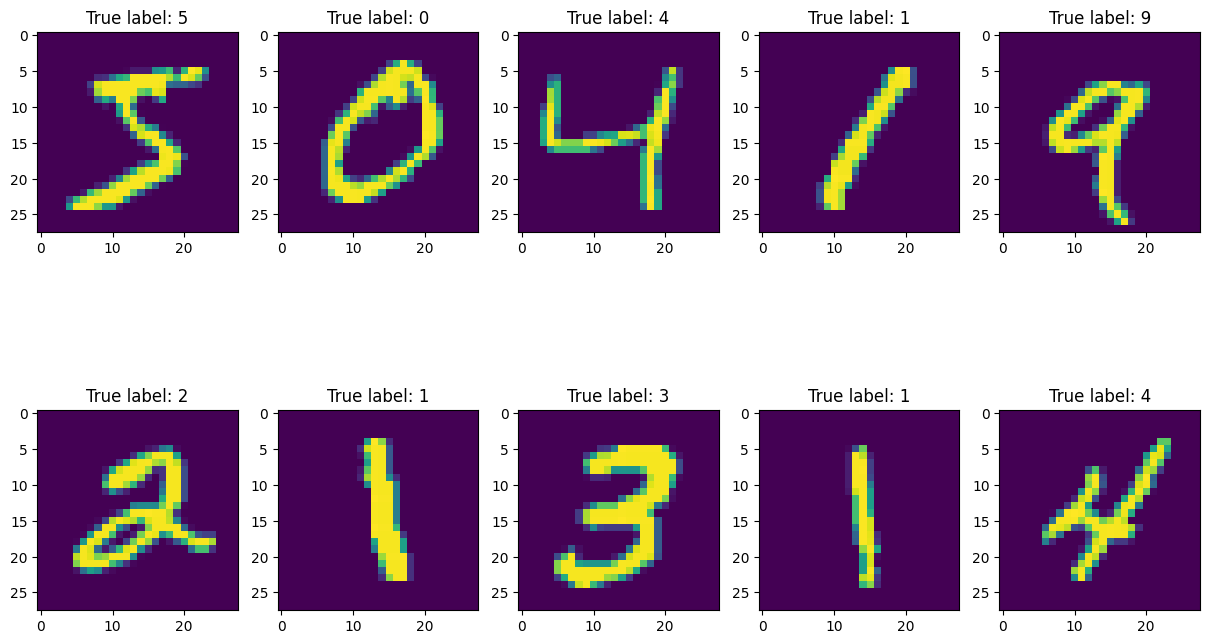

MNIST images are of shapes (28, 28) which leads to 784 dimensions (pixels)


In [61]:
plt.figure(figsize=(15, 9))
for i in range(10):
    plt.subplot(2,5,i+1)
    image = trainset[i][0]
    image_true_label = trainset[i][1]
    plt.title("True label: {}".format(image_true_label))
    plt.imshow(image)

plt.show()

# What are the shapes and the sizes of the images?
im_shape = np.array(trainset[0][0]).shape
total_pixels = np.prod(im_shape)
print("MNIST images are of shapes {} which leads to {} dimensions (pixels)".format(im_shape,total_pixels))

In [62]:
# We normalize the data (inputs) to avoid numerical instability

from torchvision import transforms

# Define a transform to normalize the data:
transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean = 0.1307, std = 0.3081) ])

# Download (it should have been done earlier, normally) and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # on prend des puissances de 2 pour une bonne parallélisation des tenseurs
testloader = torch.utils.data.DataLoader(testset, batch_size = 10000)

In [63]:
# Goal: Define the network architecture as a new nn.Module subclass
# Compared to the sequential way of defining your network,

class ReluNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)

        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)

        # Define Relu activation and softmax output
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)

        return x

# Instantiate the model
model = ReluNetwork()

# Define the loss
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [64]:
# GOAL: train the network with your optimizer over 5 epochs and  returns the training loss,
# the test loss, and the criterion at the end of each epoch

epochs = 10


for e in range(epochs):
    running_loss = 0
    running_test_loss=0

    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad() # What is this line for ?

        output = model.forward(images)
        loss = criterion(output, labels)

        # now: backpropagate and perform one optimization step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    #Compute validation loss
    with torch.no_grad():
        for images, labels in testloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Complete those lines:
            outputs = model.forward(images)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()

            predictions = torch.argmax(outputs, 1)
            correct_test = torch.sum(predictions==labels)

            test_accuracy = 100*correct_test/len(predictions)

        print("Epoch number", e+1)
        print("Training loss: ", round(running_loss/len(trainloader),3))
        print("Test loss: ", round(running_test_loss/len(testloader),3))
        print("Test Accuracy: ", round(test_accuracy.item(), 2), "%")

Epoch number 1
Training loss:  1.649
Test loss:  1.548
Test Accuracy:  92.6 %
Epoch number 2
Training loss:  1.543
Test loss:  1.533
Test Accuracy:  93.49 %
Epoch number 3
Training loss:  1.527
Test loss:  1.521
Test Accuracy:  94.52 %
Epoch number 4
Training loss:  1.518
Test loss:  1.515
Test Accuracy:  95.18 %
Epoch number 5
Training loss:  1.51
Test loss:  1.51
Test Accuracy:  95.53 %
Epoch number 6
Training loss:  1.504
Test loss:  1.506
Test Accuracy:  96.1 %
Epoch number 7
Training loss:  1.5
Test loss:  1.503
Test Accuracy:  96.26 %
Epoch number 8
Training loss:  1.496
Test loss:  1.498
Test Accuracy:  96.72 %
Epoch number 9
Training loss:  1.493
Test loss:  1.498
Test Accuracy:  96.78 %
Epoch number 10
Training loss:  1.49
Test loss:  1.496
Test Accuracy:  97.0 %


In [70]:
# Goal: Define a training **function** that returns the training loss,
# the test loss, and the criterion at the end of each epoch

def training(model,
             criterion=nn.CrossEntropyLoss(),
             optim_alg="SGD",
             lr=0.01,
             momentum=(.9, .999),
             schedule=False,
             nb_epochs=5,
             intermediate_prints=False,
            ):

    if optim_alg == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum[0])
    elif optim_alg == "ADAM":
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=momentum)
    else:
        raise ValueError("optim_alg must take its value in {}".format(["SGD", "ADAM"]))

    if schedule:
        scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=1)

    epoch_train_losses_list = []
    epoch_test_losses_list = []
    epoch_accuracy_list = []

    for e in range(nb_epochs):
        running_loss = 0
        running_test_loss=0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector

            images = images.view(images.shape[0], -1)

            # Training pass
            optimizer.zero_grad()

            # Evaluate the output, loss, backpropagate and perform an optimization step:
            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()



        #Compute validation loss
        with torch.no_grad():
            for images, labels in testloader:
                # Flatten MNIST images into a 784 long vector
                images = images.view(images.shape[0], -1)

                # Update the validation loss and compute accuracy:
                outputs = model.forward(images)
                test_loss = criterion(outputs, labels)
                running_test_loss += test_loss.item()

                predictions = torch.argmax(outputs, 1)
                correct_test = torch.sum(predictions==labels)
                test_accuracy = 100*correct_test/len(predictions)

        final_train_loss = running_loss/len(trainloader)
        final_test_loss = running_test_loss/len(testloader)

        if intermediate_prints:
            print("Epoch number: {}".format(e+1))
            print("Training loss = {} ".format(round(final_train_loss,3)))
            print("Test loss = {} ".format(round(final_test_loss,3)))
            print("Test Accuracy:", round(test_accuracy.item(), 2), "%")

        epoch_train_losses_list.append(final_train_loss)
        epoch_test_losses_list.append(final_test_loss)
        epoch_accuracy_list.append(test_accuracy)

        if schedule:
            scheduler.step(final_test_loss)

    return epoch_train_losses_list, epoch_test_losses_list, epoch_accuracy_list

In [71]:
nb_epochs = 10

# Training of the model
epoch_train_losses_list, epoch_test_losses_list, epoch_accuracy_list = training(
    model,
    criterion=nn.CrossEntropyLoss(),
    optim_alg="SGD",
    lr=0.01,
    momentum=(0., ),
    schedule=False,
    nb_epochs=nb_epochs,
    intermediate_prints=True,
)

print(
    np.array([
        round(epoch_train_losses_list[-1], 3),
        round(epoch_test_losses_list[-1], 3), 100*epoch_accuracy_list[-1]
    ]), 9)

Epoch number: 1
Training loss = 1.485 
Test loss = 1.493 
Test Accuracy: 97.18 %
Epoch number: 2
Training loss = 1.484 
Test loss = 1.493 
Test Accuracy: 97.18 %
Epoch number: 3
Training loss = 1.484 
Test loss = 1.493 
Test Accuracy: 97.2 %
Epoch number: 4
Training loss = 1.484 
Test loss = 1.493 
Test Accuracy: 97.26 %
Epoch number: 5
Training loss = 1.484 
Test loss = 1.493 
Test Accuracy: 97.28 %
Epoch number: 6
Training loss = 1.484 
Test loss = 1.493 
Test Accuracy: 97.23 %
Epoch number: 7
Training loss = 1.484 
Test loss = 1.493 
Test Accuracy: 97.29 %
Epoch number: 8
Training loss = 1.483 
Test loss = 1.493 
Test Accuracy: 97.22 %
Epoch number: 9
Training loss = 1.483 
Test loss = 1.492 
Test Accuracy: 97.28 %
Epoch number: 10
Training loss = 1.483 
Test loss = 1.492 
Test Accuracy: 97.27 %
[1.483e+00 1.492e+00 9.727e+03] 9


Let's visualize the predictions of the model for some random test images: for a minibatch of size 10 of test images, the following code prints the image, its label, the corresponding prediction given by the network, and the network accuracy on the minibatch.

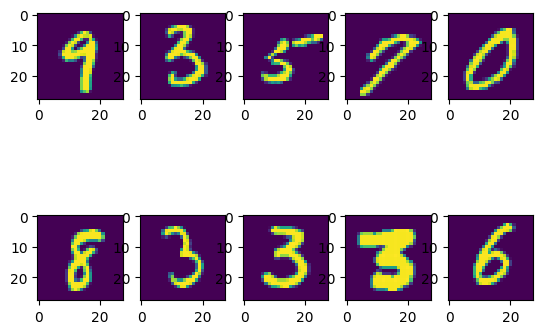

Predictions are tensor([9, 3, 5, 7, 0, 8, 3, 3, 3, 6])
True labels are tensor([9, 3, 5, 7, 0, 8, 3, 3, 3, 6])
test accuracy on this minibatch of size 10 is 100 % 


In [67]:
test_batch_size = 10
minitestloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)
running_loss = 0
running_test_loss = 0
u = 0

for images, labels in minitestloader:
    if u < 1:

        for i in range(test_batch_size):
            plt.subplot(2, int(test_batch_size / 2), i + 1)
            plt.imshow(images[i][0])
        plt.show()

        images = images.view(images.shape[0], -1)
        outputs = model(images)
        test_loss = criterion(outputs, labels)
        running_test_loss += test_loss.item()

        predictions = torch.argmax(outputs, 1)
        print('Predictions are', predictions)
        print('True labels are', labels)
        correct_test = predictions.eq(labels).sum().item()

        print('test accuracy on this minibatch of size %d is %.0f %% ' %
              (test_batch_size, 100 * correct_test / test_batch_size))

        test_accuracy = 100 * correct_test / len(predictions)
        u = u + 1

The cell below plots the training and test error as a function of the number of epochs.

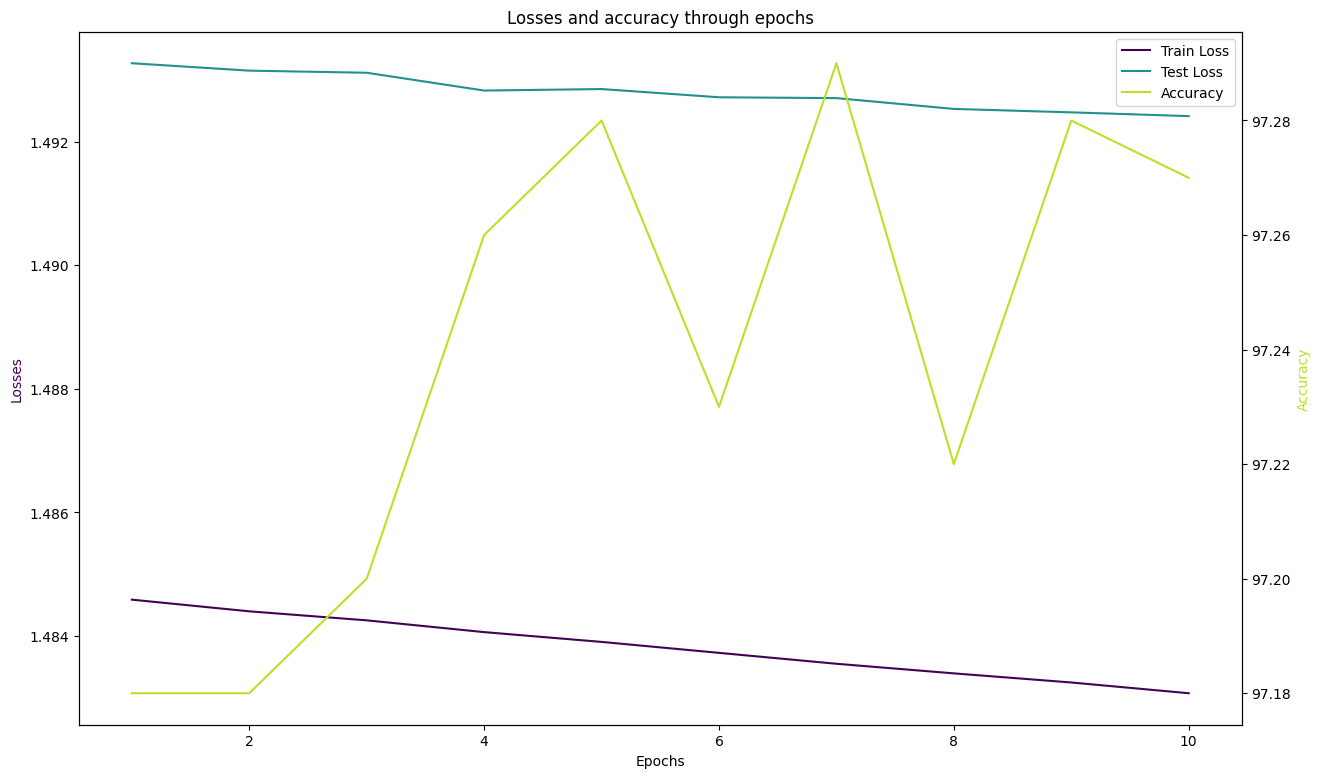

In [72]:
# Plot losses and accuracy curves of the first training through time

fig = plt.figure(figsize=(15, 9))
host = fig.add_subplot(111)
secondary = host.twinx()

host.set_xlabel("Epochs")
host.set_ylabel("Losses")
secondary.set_ylabel("Accuracy")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5)
color3 = plt.cm.viridis(.9)

p1, = host.plot(np.arange(nb_epochs)+1, epoch_train_losses_list, color=color1, label="Train Loss")
p2, = host.plot(np.arange(nb_epochs)+1, epoch_test_losses_list, color=color2, label="Test Loss")
p3, = secondary.plot(np.arange(nb_epochs)+1, epoch_accuracy_list, color=color3, label="Accuracy")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
secondary.yaxis.label.set_color(p3.get_color())

plt.title("Losses and accuracy through epochs")

plt.show()

Accuracy tends to increase as the number of epoch increases. The plot we get is however not the best to see this.

In [ ]:
# We will compare the performances between the optimizers:
# Compare several optimization algorithms performance

start_time = time.time()

# Training the same architecture with different losses
nb_epochs = 5

# SGD w/o momentum
epoch_train_losses_list1, epoch_test_losses_list1, epoch_accuracy_list1 = training(ReluNetwork(),
                                                                                   criterion=nn.NLLLoss(),
                                                                                   optim_alg="SGD",
                                                                                   lr=0.01,
                                                                                   momentum=(0.,),
                                                                                   schedule=False,
                                                                                   nb_epochs=nb_epochs,
                                                                                   intermediate_prints=False,
                                                                                  )

# SGD w/ momentum
epoch_train_losses_list2, epoch_test_losses_list2, epoch_accuracy_list2 = training(ReluNetwork(),
                                                                                   criterion=nn.NLLLoss(),
                                                                                   optim_alg="SGD",
                                                                                   lr=0.01,
                                                                                   momentum=(0.9,),
                                                                                   schedule=False,
                                                                                   nb_epochs=nb_epochs,
                                                                                   intermediate_prints=False,
                                                                                  )

# ADAM
epoch_train_losses_list3, epoch_test_losses_list3, epoch_accuracy_list3 = training(ReluNetwork(),
                                                                                   criterion=nn.NLLLoss(),
                                                                                   optim_alg="ADAM",
                                                                                   lr=0.01,
                                                                                   momentum=(0.9, 0.999),
                                                                                   schedule=False,
                                                                                   nb_epochs=nb_epochs,
                                                                                   intermediate_prints=False,
                                                                                  )

# SGD with scheduler
epoch_train_losses_list4, epoch_test_losses_list4, epoch_accuracy_list4 = training(ReluNetwork(),
                                                                                   criterion=nn.NLLLoss(),
                                                                                   optim_alg="SGD",
                                                                                   lr=0.1,
                                                                                   momentum=(0.,),
                                                                                   schedule=True,
                                                                                   nb_epochs=nb_epochs,
                                                                                   intermediate_prints=False,
                                                                                  )

# Plot curves
fig = plt.figure(figsize=(15, 9))

plt.subplot(1,3,1)
plt.plot(np.arange(nb_epochs)+1, epoch_train_losses_list1, color=plt.cm.viridis(0))
plt.plot(np.arange(nb_epochs)+1, epoch_train_losses_list2, color=plt.cm.viridis(0.5))
plt.plot(np.arange(nb_epochs)+1, epoch_train_losses_list3, color=plt.cm.viridis(.9))
plt.plot(np.arange(nb_epochs)+1, epoch_train_losses_list4, color=plt.cm.viridis(1.3))
plt.legend(["SGD w/o momentum", "SGD w/ momentum", "ADAM", "SGD with scheduler"])
plt.xlabel("Epochs")
plt.ylabel("Train losses")

plt.subplot(1,3,2)
plt.title("Losses and accuracy through epochs with several optimization algorithms")
plt.plot(np.arange(nb_epochs)+1, epoch_test_losses_list1, color=plt.cm.viridis(0))
plt.plot(np.arange(nb_epochs)+1, epoch_test_losses_list2, color=plt.cm.viridis(0.5))
plt.plot(np.arange(nb_epochs)+1, epoch_test_losses_list3, color=plt.cm.viridis(.9))
plt.plot(np.arange(nb_epochs)+1, epoch_test_losses_list4, color=plt.cm.viridis(1.3))
plt.legend(["SGD w/o momentum", "SGD w/ momentum", "ADAM", "SGD with scheduler"])
plt.xlabel("Epochs")
plt.ylabel("Test losses")

plt.subplot(1,3,3)
plt.plot(np.arange(nb_epochs)+1, epoch_accuracy_list1, color=plt.cm.viridis(0))
plt.plot(np.arange(nb_epochs)+1, epoch_accuracy_list2, color=plt.cm.viridis(0.5))
plt.plot(np.arange(nb_epochs)+1, epoch_accuracy_list3, color=plt.cm.viridis(.9))
plt.plot(np.arange(nb_epochs)+1, epoch_accuracy_list4, color=plt.cm.viridis(1.3))
plt.legend(["SGD w/o momentum", "SGD w/ momentum", "ADAM", "SGD with scheduler"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()